# COURSE ASSESSMENT: MACHINE LEARNING IN HEALTHCARE
## Topic: Exploratory Data Analysis (EDA) and Building a Linear Regression Model for Predicting Course Grades
### Objectives:
- Apply EDA techniques to better understand student grade data.
- Build and evaluate a Linear Regression model to predict the final course grade (HP_grade) based on other grade components.
- Analyze and interpret the results of the model.
#### Data: Use the data provided (extracted from the file in the link). The data includes information on quiz scores (KT1, KT2, KT3), average quiz score (KT_TB), bonus points (Bonus), report score (BC), process score (QT_x or QT_Y), and final exam score (CK), ultimately leading to the final course grade (HP_grade). 

Nguyen Duc Hung - 20233960


# Install dependencies and import:

dependencies can be install via dependencies.yml

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Choosing the suitable independent variable

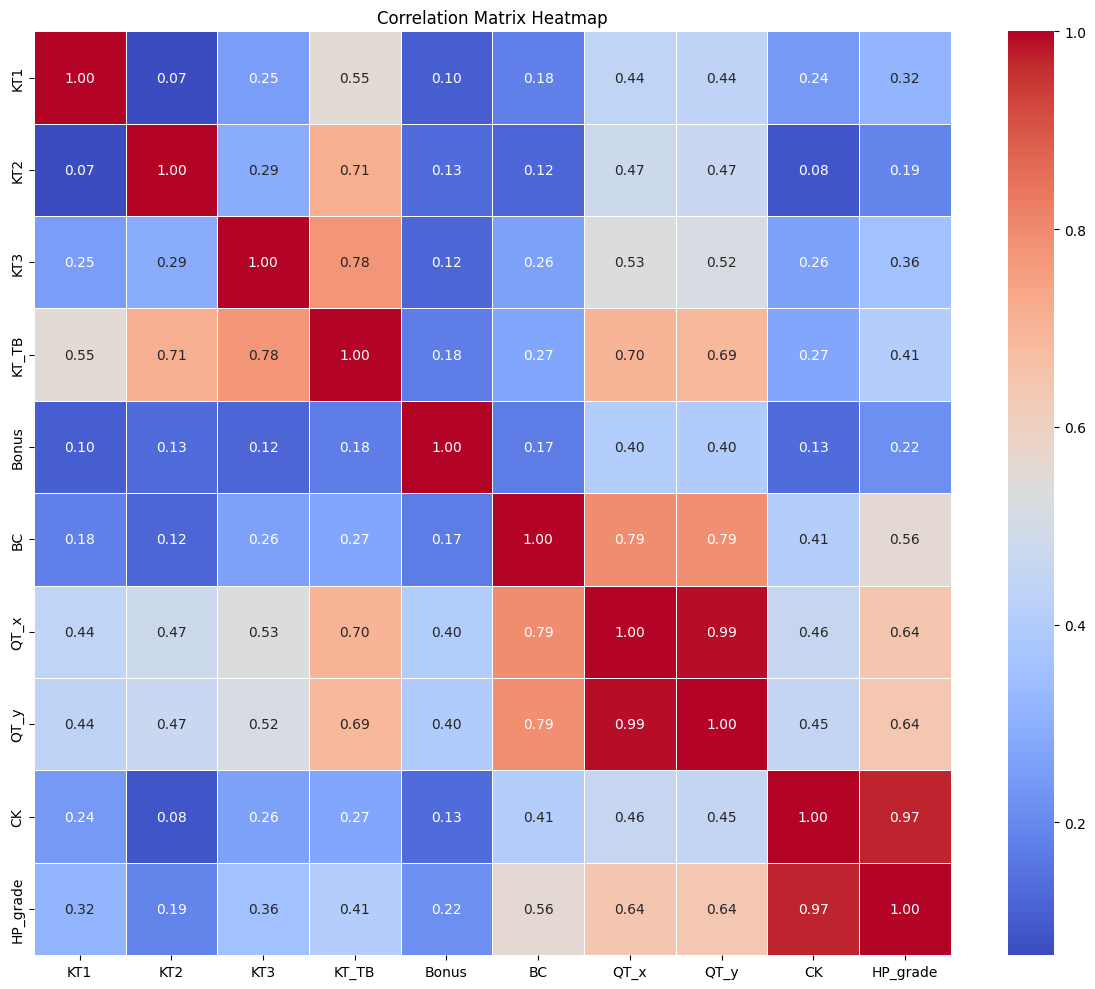

In [82]:
df = pd.read_csv("data/csv/combined_data.csv")
# Compute correlation matrix for all numeric columns
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

- My initial selection of independent variables for predicting HP_grade would be: CK; QT_y; BC; Potentially one of the KT variables (likely KT_TB if we choose to include one directly)
- KT_TB should be used, and used alone, since KT_TB is the average, it is highly collinear to KT1, KT2 and KT3

Rationale for Selection:

- High Correlation with HP_grade: The primary criterion is selecting features that show a strong positive linear relationship with the target variable, HP_grade. CK stands out significantly in this regard. QT_y and BC also have respectable correlations.
Avoiding Multicollinearity (Consideration): We need to be cautious about including highly correlated independent variables, as this can lead to unstable model coefficients and difficulty in interpretation.
- QT_x and QT_y have a very high correlation (0.99), indicating they are practically duplicates. We should definitely choose only one of them. Since QT_y has a slightly higher correlation with HP_grade (0.64 vs 0.46 for QT_x), I've tentatively selected QT_y.
- CK and QT_y have a moderate positive correlation (0.45). While not extremely high, it's something to monitor during model building. If multicollinearity becomes a significant issue, we might need to reconsider including both or explore techniques like PCA (as discussed before, although less directly applied to just two variables).
- BC has moderate correlations with CK (0.41) and QT_y (0.79). The higher correlation with QT_y suggests some shared variance, but its individual correlation with HP_grade warrants its initial inclusion.

# Step 2: Load the data and split training and testing data

2.	(1 point) Split the dataset into a training set and a test set using an appropriate ratio (e.g., 80/20 or 70/30). Explain why this data splitting is necessary. First, we make a list of our wanted features:

In [83]:
df_copy = df.copy()
X = df[["CK", "QT_y", "KT_TB", "BC"]]  # Features (Predictors)
y = df["HP_grade"]  # Target variable

Then, we split the training data:

- 80% training data provides enough information for the model to learn patterns effectively.
- 20% test data ensures a reliable estimate of how the model performs on unseen data.

In [84]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We take a small peek to the training and testing dataset to see if spliting and choosing sucesss:

In [85]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

(304, 4)
(304,)
(77, 4)
(77,)
      CK  QT_y     KT_TB    BC
78   4.5   7.0  5.543333  8.50
265  7.0   8.0  6.613333  8.50
93   6.5   7.0  6.096667  7.75
377  9.0   9.5  8.256667  7.75
272  7.5   6.5  5.313333  7.00
78     5.3
265    7.3
93     6.7
377    9.0
272    7.2
Name: HP_grade, dtype: float64
      CK  QT_y     KT_TB    BC
266  8.0   7.0  6.583333  7.00
192  7.0   7.5  8.473333  6.25
46   4.5   6.0  5.696667  7.00
55   6.5   6.0  6.343333  5.50
57   7.5   7.5  7.666667  7.50
266    7.7
192    7.2
46     5.0
55     6.4
57     7.5
Name: HP_grade, dtype: float64


There are 304 samples for training and 77 for testing.

# Step 3: Initialize and train the model:

3.	(3 points) Using the training set, build a Linear Regression model to predict HP_grade from the selected features. Print the model's coefficients (intercept and slopes).

Then, we initiate the learning model:

In [86]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)


We can get regression coefficients with ```lr.coef_``` and ```lr.intercept_```

In [87]:
# Get the coefficients (slope values for each feature)
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_})
print(coeff_df)

# Get the intercept (y-intercept)
intercept = lr.intercept_

print("Intercept:", intercept)

  Feature  Coefficient
0      CK     0.705498
1    QT_y     0.233393
2   KT_TB     0.022791
3      BC     0.044039
Intercept: -0.02317343002171146


4.	(1 point) Explain the meaning of the intercept and at least 2 coefficients (slopes) of the independent variables you consider most important in the model.

## Step 4: Interpretation of Regression Output

Here's an explanation of the intercept and coefficients for some important independent variables from the linear regression model:

**Intercept:**

The intercept is **-0.02317343002171146**. This represents the predicted value of `HP_grade` when all independent variables (CK, QT_y, KT_TB, and BC) are equal to zero. It serves as the baseline prediction when all predictors have no value. Note that the practical interpretation of this value depends on whether a zero value for all predictors is meaningful in the real-world context.

**Coefficients of Important Independent Variables:**

1.  **Coefficient of CK: 0.705498**

    * **Meaning:** For every one-unit increase in `CK`, while holding `QT_y`, `KT_TB`, and `BC` constant, the predicted `HP_grade` increases by approximately **0.705 units**.
    * **Importance:** This relatively large positive coefficient indicates that `CK` has a strong positive impact on the predicted `HP_grade`, aligning with our EDA findings of a very strong positive correlation.

2.  **Coefficient of QT\_y: 0.233393**

    * **Meaning:** For every one-unit increase in `QT_y`, while holding `CK`, `KT_TB`, and `BC` constant, the predicted `HP_grade` increases by approximately **0.233 units**.
    * **Importance:** The positive coefficient suggests that `QT_y` also contributes positively to the prediction of `HP_grade`. While the impact is smaller than that of `CK` on a per-unit basis, it still plays a significant role, consistent with the strong positive correlation observed in the EDA.

In summary, the intercept provides a baseline prediction, and the coefficients quantify the change in the predicted `HP_grade` for a one-unit increase in each independent variable, keeping others constant. The coefficients for `CK` and `QT_y` indicate a positive relationship with `HP_grade`, with `CK` having a more substantial impact based on its larger coefficient.

# Step 5: Grading model 

1.	(2 points) Using the test set, make predictions for HP_grade with the trained model. Calculate and present the following regression performance evaluation metrics: 
-	R-squared (Coefficient of Determination)
-	Mean Absolute Error (MAE)
-	Mean Squared Error (MSE)
-	Root Mean Squared Error (RMSE)


We evaluate model performance using mean squared error, root mean squared error and R^2.

In [88]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred) # Calculate MAE

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}") # Print MAE

Mean Squared Error: 0.004231
Root Mean Squared Error: 0.0650
R-squared (R²): 0.9979
Mean Absolute Error (MAE): 0.0429


### Step 7: Overall, models work exceptionally well. With R value very close to 1(proving linearity) and the grade only deviate at the rate of 0.0650 in scale of 10

### Step 8: Scatter Plot of Actual and predicted data

3.	(1 point) Visualize the prediction results on the test set by plotting a scatter plot of actual HP_grade values versus predicted HP_grade values. Comment on how well the predictions align with the actual values. Provide an overall conclusion about the model's ability to predict the course grade.

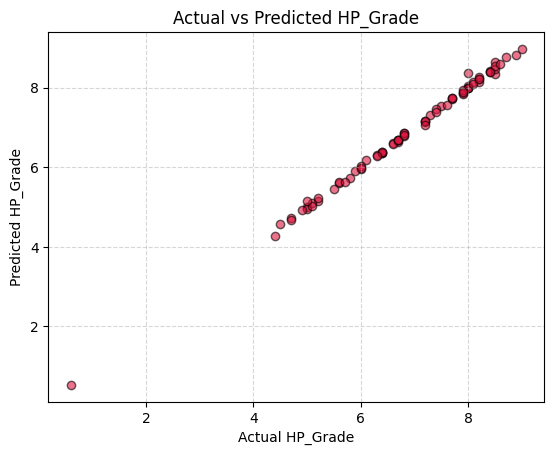

In [89]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Step 4: Optimization

### Step 7: Overall, models work exceptionally well. With R value very close to 1 and the grade only deviate at the rate of 0.0650 in scale of 10

## Approach 1: Anomaly removal

In EDA, we have seen some failed students across the columns, let's try to remove them:


In [90]:
df = df[df["HP_grade"] >= 3]
df = df[df["QT_y"] >= 3]
df = df[df["CK"] >= 3]

In [91]:
X = df[["CK", "QT_y", "BC", "KT_TB"]]  # Features (Predictors)
y = df["HP_grade"]  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [92]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)

In [93]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred) # Calculate MAE

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}") # Print MAE

Mean Squared Error: 0.004282
Root Mean Squared Error: 0.0654
R-squared (R²): 0.9975
Mean Absolute Error (MAE): 0.0439


We see that reducing anomalies make model worse. We have deleted valuable data.

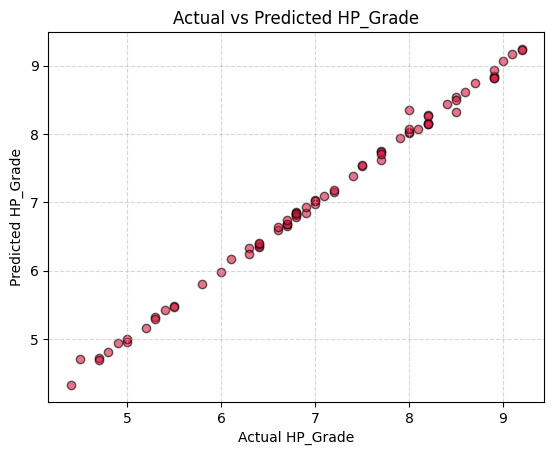

In [94]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Approach 2: Apply K-Fold training

- K-Fold Cross-Validation is a technique used to evaluate a model's performance by splitting the dataset into K equal parts (folds) and training the model multiple times on different subsets of the data.

1. How Does K-Fold Work?
- Divide the dataset into K folds
- If K=5, the dataset is split into 5 equal parts. Train the model K times
- Each time, use K-1 folds for training and 1 fold for testing. Compute the average performance
- The final result is the mean of all K test scores, giving a more reliable estimate of model performance.
2. Why Use K-Fold?
- Reduces Bias → Uses all data for both training & testing.
- More Reliable → Reduces dependency on a single train-test split.
- Better for Small Datasets → Maximizes data usage.

In [95]:
X = df_copy[["CK", "QT_y", "BC", "KT_TB"]]  # Features (Predictors)
y = df_copy["HP_grade"]  # Target variable

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV
model = LinearRegression()

# Perform Cross-Validation
mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert to positive MSE values
mse_scores = -mse_scores

# Print results
print(f'MSE Scores for each fold: {mse_scores}')
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Standard Deviation of MSE: {np.std(mse_scores)}')


MSE Scores for each fold: [0.00423112 0.00534215 0.0080454  0.00346138 0.00776479]
Average MSE: 0.005768967234137648
Standard Deviation of MSE: 0.0018459437828313573


The average MSE is better than original model's MSE by a huge margin indeed